# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
# disable gpu
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


## Uncomment w
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import glob
import joblib

In [4]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [5]:
RATIO_TO_PREDICT = "BTCBUSD"
FUTURE_PERIOD_PREDICT = 1

## Loading data

Load csv files obtained using binance API

In [6]:
main_df = pd.DataFrame()

binance_symbols = ['BTCBUSD','OCEANBUSD','ZRXBUSD','ATOMBUSD','BNTBUSD','ALGOBUSD','TWTBUSD','SUSHIBUSD']

for ratio in binance_symbols:
    
    dataset = "crypto_data/final_data_05_07_2021/"+ratio+"-1m-data.csv"
    df = pd.read_csv(dataset, index_col="timestamp")
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)

    df = df[[f"{ratio}_close"]]
    
    df = df[(df.index < "2021-07-01 13:00:00")] 
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df, on='timestamp')


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216177 entries, 2021-02-01 00:00:00 to 2021-07-01 12:59:00
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BTCBUSD_close    216177 non-null  float64
 1   OCEANBUSD_close  216177 non-null  float64
 2   ZRXBUSD_close    216177 non-null  float64
 3   ATOMBUSD_close   216177 non-null  float64
 4   BNTBUSD_close    216177 non-null  float64
 5   ALGOBUSD_close   216177 non-null  float64
 6   TWTBUSD_close    216177 non-null  float64
 7   SUSHIBUSD_close  216177 non-null  float64
dtypes: float64(8)
memory usage: 14.8+ MB


In [8]:
main_df.describe()

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
count,216177.00000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000
mean,48114.12975,1.062732,1.402031,18.256147,5.709224,1.158394,0.591984,14.100699
std,9384.01731,0.409759,0.423119,4.955177,1.896858,0.231497,0.183367,3.556966
min,28860.09000,0.323200,0.499100,7.838000,1.827600,0.618900,0.230000,6.002000
25%,37930.03000,0.635400,1.039800,13.759000,4.017700,0.995500,0.494100,11.761000
50%,49735.22000,1.120100,1.437700,19.243000,6.120700,1.135800,0.588200,14.694000
75%,56629.16000,1.417500,1.714000,21.784000,7.392400,1.352600,0.695000,16.394000
max,64842.71000,1.938500,2.403700,32.125000,9.363300,1.844800,1.301700,23.411000


Because there are some NaN values we will get rid of them using code below.

In [9]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 8 columns from which we will be using only close prices.

In [10]:
main_df.head(3)

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
timestamp,,,,,,,,
2021-02-01 00:00:00,33071.43,0.5470,0.7037,8.143,1.8732,0.6478,0.2908,10.108
2021-02-01 00:01:00,33072.65,0.5452,0.7059,8.143,1.8695,0.6478,0.2908,10.070
2021-02-01 00:02:00,32912.95,0.5433,0.7016,8.132,1.8637,0.6402,0.2908,10.050


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

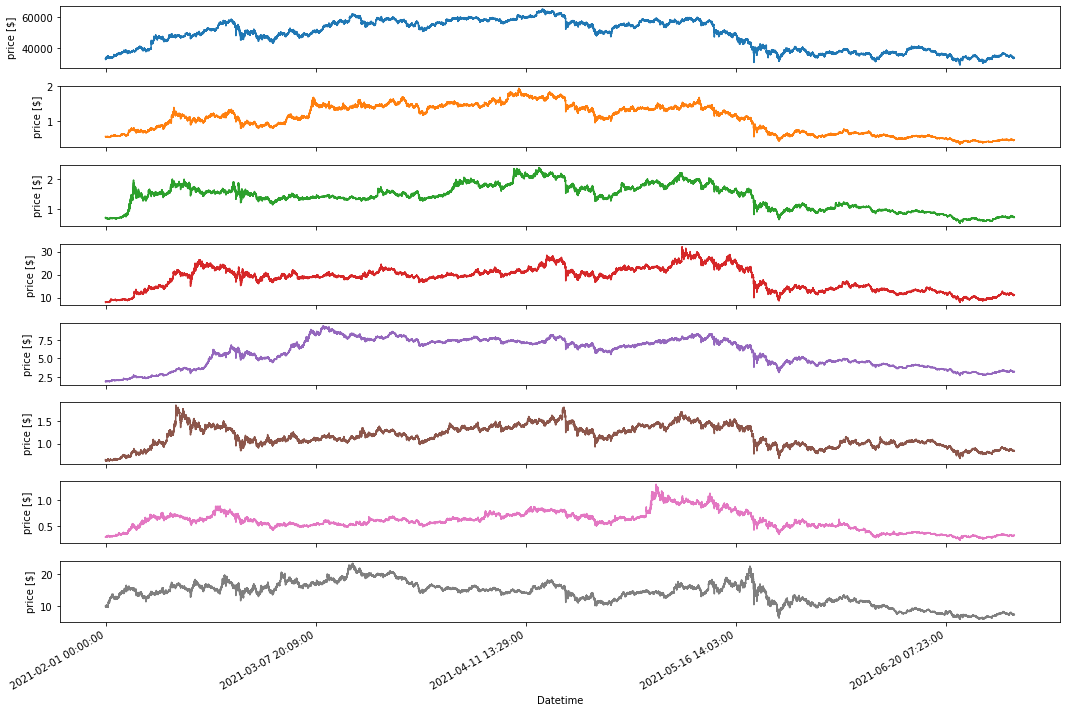

In [11]:
main_df.plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

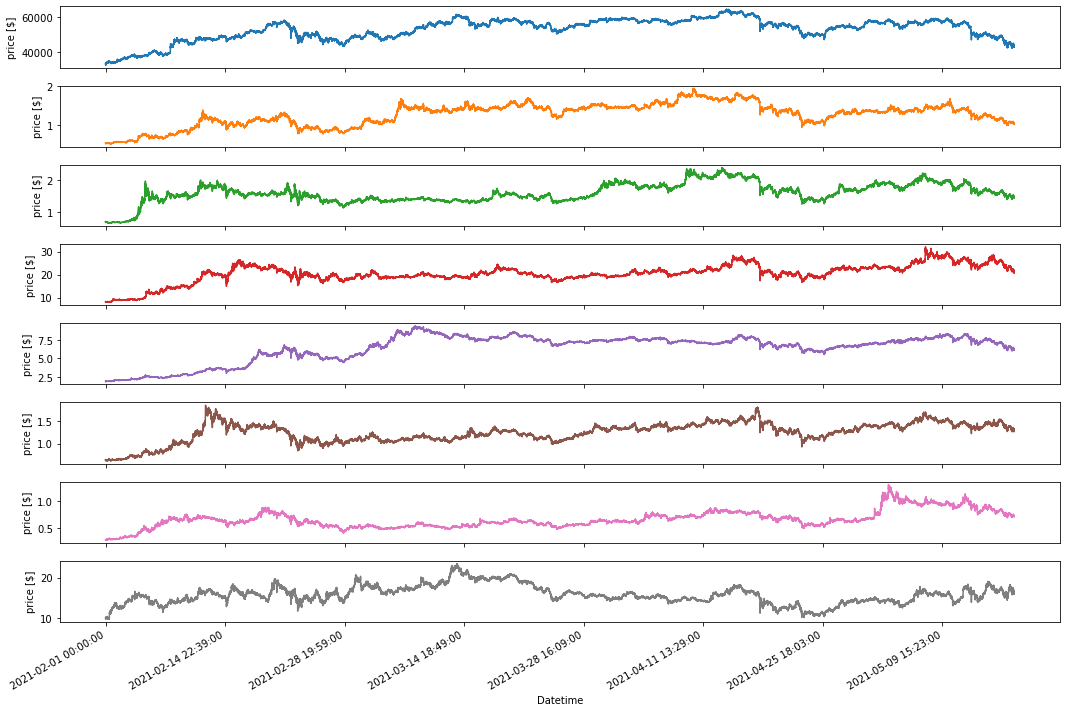

In [12]:
main_df[:152000].plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

In [13]:
main_df.describe()

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
count,216177.00000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000
mean,48114.12975,1.062732,1.402031,18.256147,5.709224,1.158394,0.591984,14.100699
std,9384.01731,0.409759,0.423119,4.955177,1.896858,0.231497,0.183367,3.556966
min,28860.09000,0.323200,0.499100,7.838000,1.827600,0.618900,0.230000,6.002000
25%,37930.03000,0.635400,1.039800,13.759000,4.017700,0.995500,0.494100,11.761000
50%,49735.22000,1.120100,1.437700,19.243000,6.120700,1.135800,0.588200,14.694000
75%,56629.16000,1.417500,1.714000,21.784000,7.392400,1.352600,0.695000,16.394000
max,64842.71000,1.938500,2.403700,32.125000,9.363300,1.844800,1.301700,23.411000


Some more info with .info()

In [14]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216177 entries, 2021-02-01 00:00:00 to 2021-07-01 12:59:00
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BTCBUSD_close    216177 non-null  float64
 1   OCEANBUSD_close  216177 non-null  float64
 2   ZRXBUSD_close    216177 non-null  float64
 3   ATOMBUSD_close   216177 non-null  float64
 4   BNTBUSD_close    216177 non-null  float64
 5   ALGOBUSD_close   216177 non-null  float64
 6   TWTBUSD_close    216177 non-null  float64
 7   SUSHIBUSD_close  216177 non-null  float64
dtypes: float64(8)
memory usage: 14.8+ MB


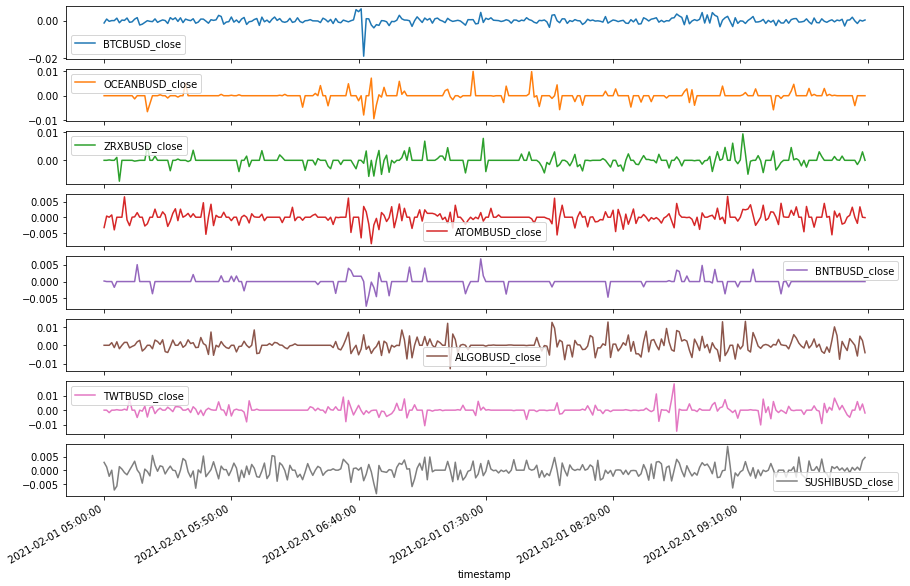

In [15]:
main_df = main_df.pct_change().copy() 
main_df[300:600].plot(subplots=True)
main_df = main_df[1:]
plt.show()

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [16]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [17]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [18]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [19]:

from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)

#joblib.dump(scaler_d, "scalers/scaler_big_pct.gz") 


""" 
scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)

scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n\nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [20]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=1,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTCBUSD_close'])
w2


Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['BTCBUSD_close']

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])


In [24]:

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 31, 8)
Inputs shape: (3, 30, 8)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [25]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [27]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

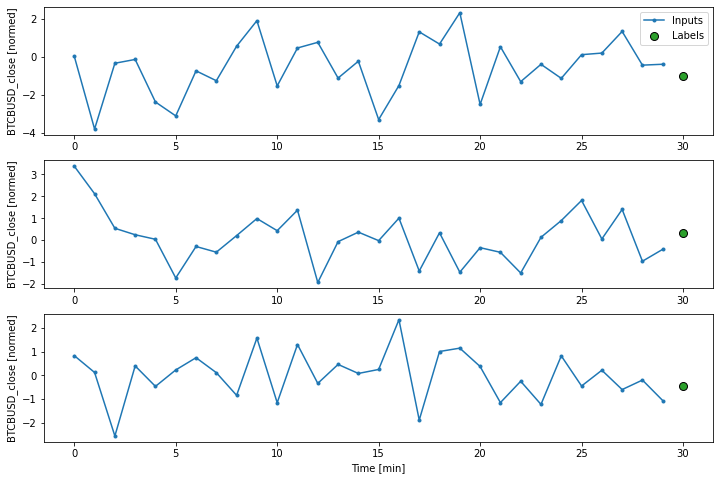

In [28]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [29]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [30]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [31]:
wide_window_d = WindowGenerator(
    input_width=30, label_width=30, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [32]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [33]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_18_07_2021_big\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=patience,
                                                        mode="min", restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = opt = tf.optimizers.Ftrl(
    learning_rate=0.0001, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.001, l2_regularization_strength=0.005,
    name='Ftrl', l2_shrinkage_regularization_strength=0.001, beta=0.9)
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [35]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [36]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [37]:
lstm = MyModel(lstm_model)

In [38]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 87s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 2/120
4728/4728 [==============================] - 80s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 3/120
4728/4728 [==============================] - 79s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 4/120
4728/4728 [==============================] - 79s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717


In [39]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 11s 8ms/step - loss: 2.4308 - mean_absolute_error: 0.9717
Loss: 2.430845260620117 MAE: 0.9716530442237854
675/675 [==============================] - 5s 8ms/step - loss: 1.3211 - mean_absolute_error: 0.7938
Loss: 1.3210644721984863 MAE: 0.7937769889831543


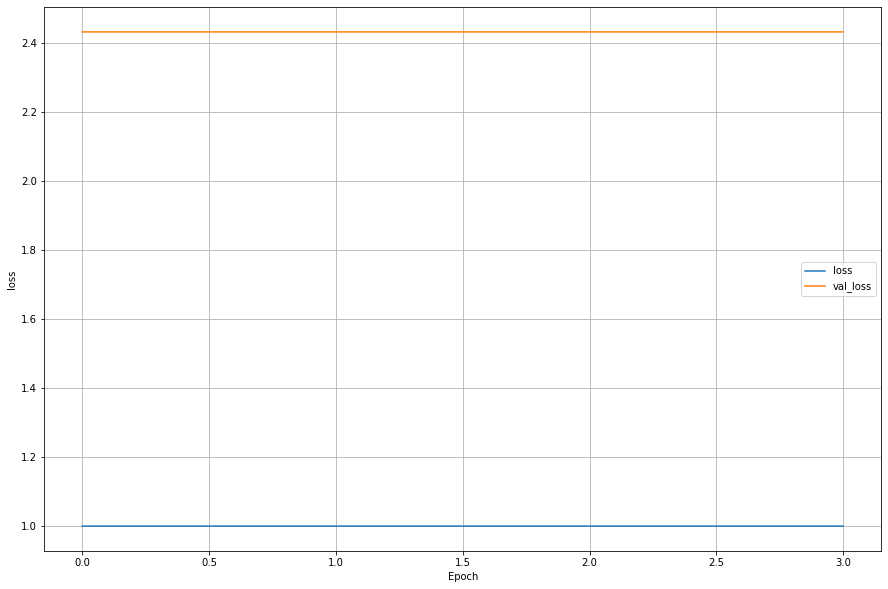

In [40]:
plot_loss(history, 'loss')

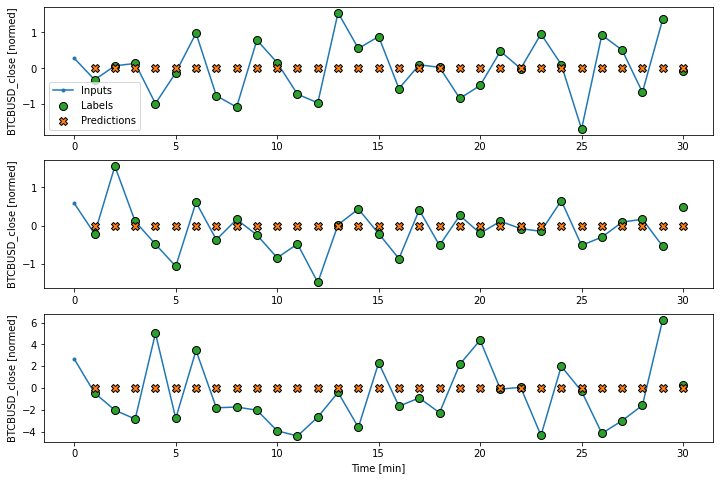

In [41]:
wide_window_d.plot(lstm.model)

In [42]:
lstm.save_model("lstm")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm.model\assets


#### Loading model

In [43]:
lstm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 256)           271360    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 30, 32)            8224      
_________________________________________________________________
dense_1 (Dense)              (None, 30, 1)             33        
Total params: 1,855,553
Trainable params: 1,855,553
Non-trainable params: 0
______________________________________________

### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [44]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [45]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [46]:
history = lstm_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 163s 33ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 2/120
4728/4728 [==============================] - 152s 32ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 3/120
4728/4728 [==============================] - 140s 30ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 4/120
4728/4728 [==============================] - 139s 29ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 5/120
4728/4728 [==============================] - 139s 29ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 6/120
4728/4728 [==============================] - 138s 29ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_abs

In [47]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 18s 13ms/step - loss: 2.4308 - mean_absolute_error: 0.9717
Loss: 2.4308481216430664 MAE: 0.9716554880142212
675/675 [==============================] - 9s 13ms/step - loss: 1.3211 - mean_absolute_error: 0.7938
Loss: 1.3210660219192505 MAE: 0.7937787771224976


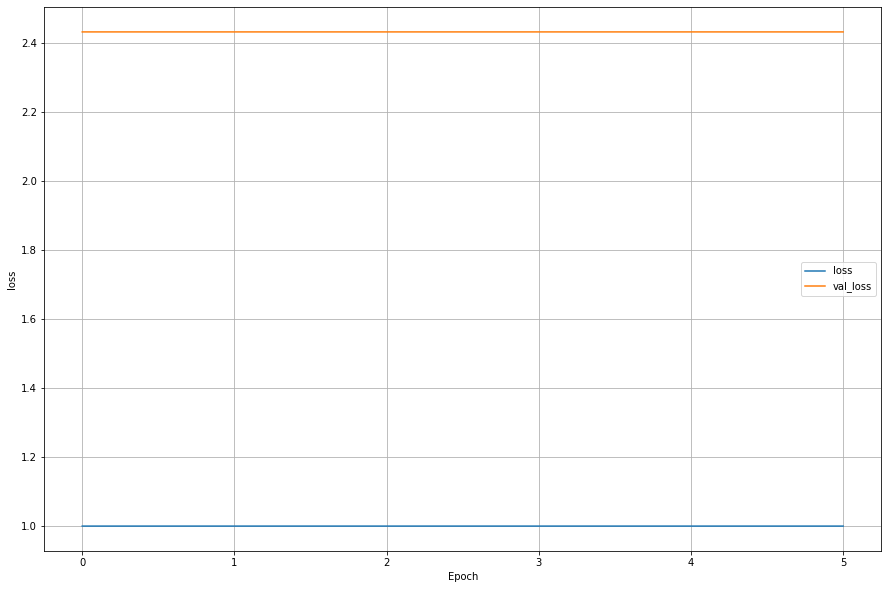

In [48]:
plot_loss(history, 'loss')

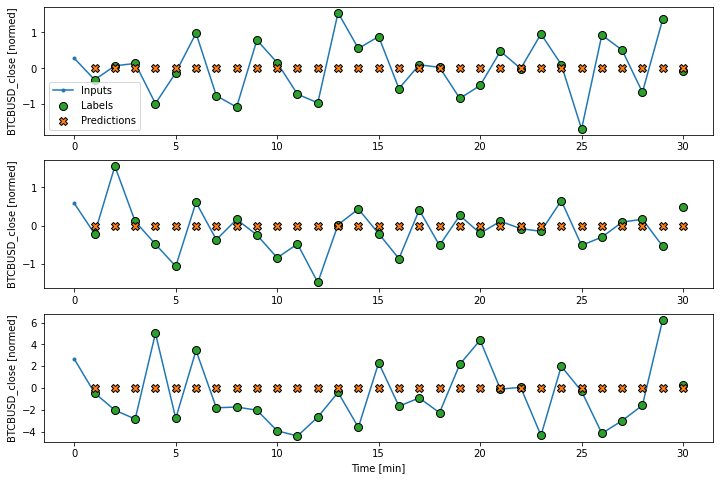

In [49]:
wide_window_d.plot(lstm_bidi.model)

In [50]:
lstm_bidi.save_model("l_bidi")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_bidi.model\assets


### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [51]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [52]:
gru = MyModel(gru_model)

In [53]:
history = gru.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 61s 12ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 2/120
4728/4728 [==============================] - 60s 13ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 3/120
4728/4728 [==============================] - 61s 13ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 4/120
4728/4728 [==============================] - 62s 13ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717


In [54]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 7s 5ms/step - loss: 2.4308 - mean_absolute_error: 0.9717
Loss: 2.43084454536438 MAE: 0.9716534614562988
675/675 [==============================] - 3s 5ms/step - loss: 1.3211 - mean_absolute_error: 0.7938
Loss: 1.321065902709961 MAE: 0.7937777638435364


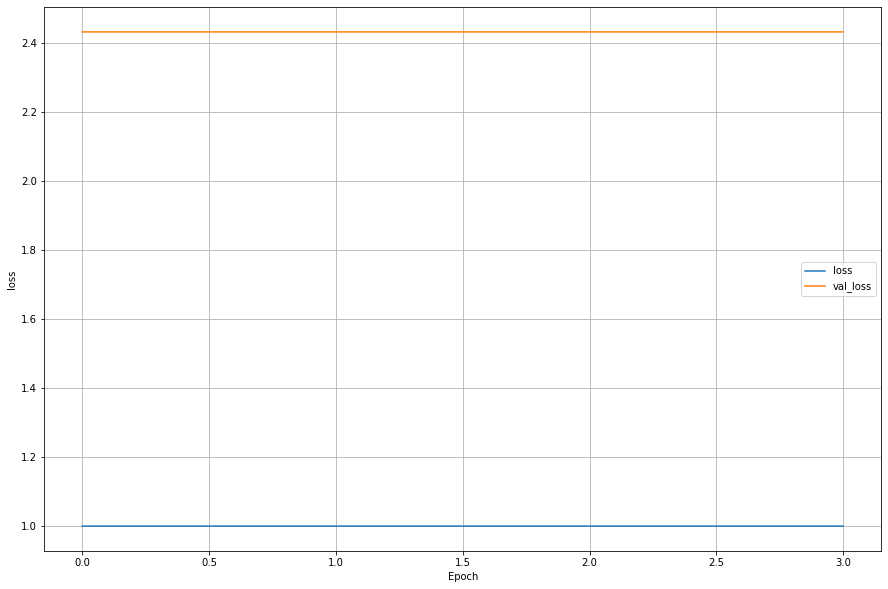

In [55]:
plot_loss(history, 'loss')

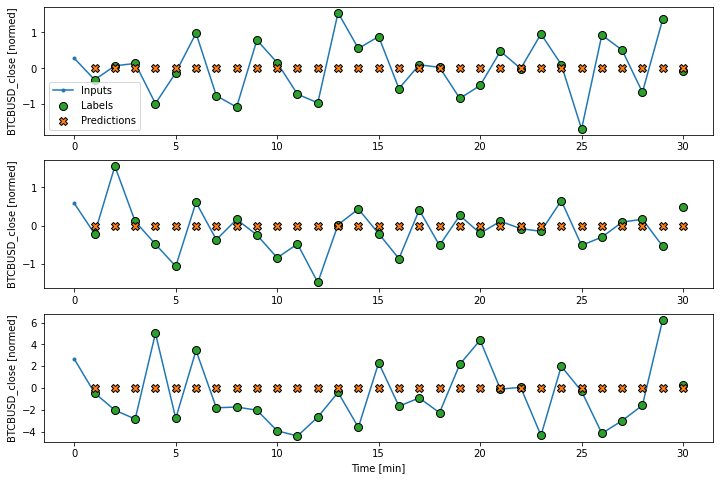

In [56]:
wide_window_d.plot(gru.model)

In [57]:
gru.save_model("gru")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru.model\assets


### Recurrent neural network (GRU - bidirectional)

In [58]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [59]:
gru_bidi = MyModel(gru_model_bidirectional)

In [60]:
history = gru_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 115s 23ms/step - loss: 0.9998 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 2/120
4728/4728 [==============================] - 113s 24ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 3/120
4728/4728 [==============================] - 116s 25ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717
Epoch 4/120
4728/4728 [==============================] - 108s 23ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4308 - val_mean_absolute_error: 0.9717


In [61]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 12s 9ms/step - loss: 2.4308 - mean_absolute_error: 0.9717
Loss: 2.4308481216430664 MAE: 0.9716548323631287
675/675 [==============================] - 6s 9ms/step - loss: 1.3211 - mean_absolute_error: 0.7938
Loss: 1.321065068244934 MAE: 0.7937777638435364


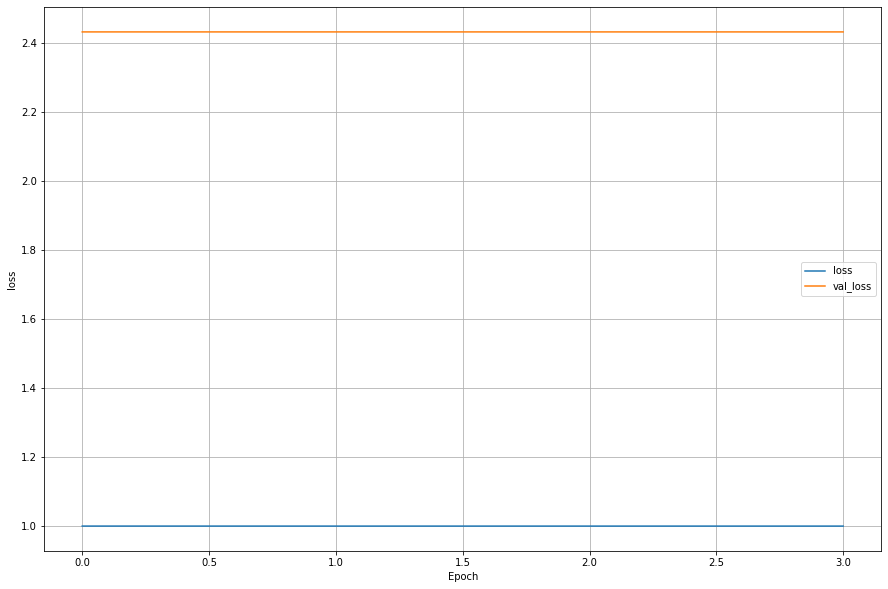

In [62]:
plot_loss(history, 'loss')

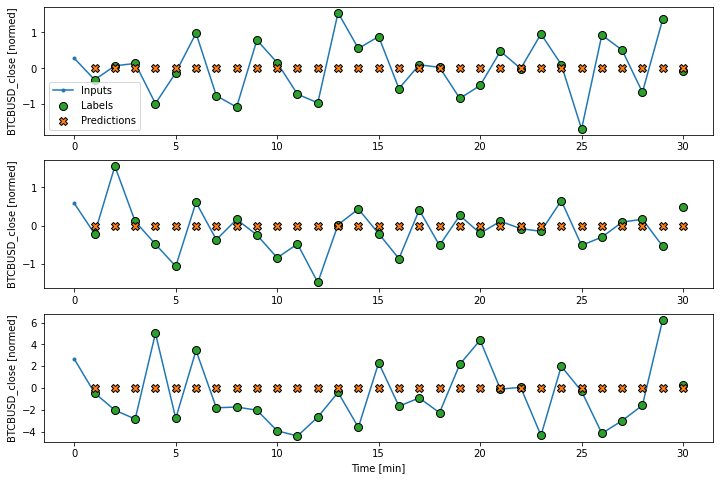

In [63]:
wide_window_d.plot(gru_bidi.model)

In [64]:
gru_bidi.save_model("g_bidi")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_bidi.model\assets


### Performance

In [65]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

"\nx = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = lstm_model.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\n\nplt.ylabel('mean_absolute_error [BTC-USD, normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()\n"

In [66]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

"\nfor name, value in performance.items():\n    print(f'{name:12s}: {value[1]:0.4f}')\n"

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [67]:
OUT_STEPS = 1

wide_window_d_single = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])


In [68]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [69]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(256, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [70]:
lstm_single = MyModel(lstm_model_single)

In [71]:
history = lstm_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 90s 18ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 2/120
4728/4728 [==============================] - 81s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 3/120
4728/4728 [==============================] - 78s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 4/120
4728/4728 [==============================] - 80s 17ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715


In [72]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 11s 8ms/step - loss: 2.4299 - mean_absolute_error: 0.9715
Loss: 2.4299473762512207 MAE: 0.9714560508728027
675/675 [==============================] - 6s 8ms/step - loss: 1.3213 - mean_absolute_error: 0.7939
Loss: 1.3213001489639282 MAE: 0.7939033508300781


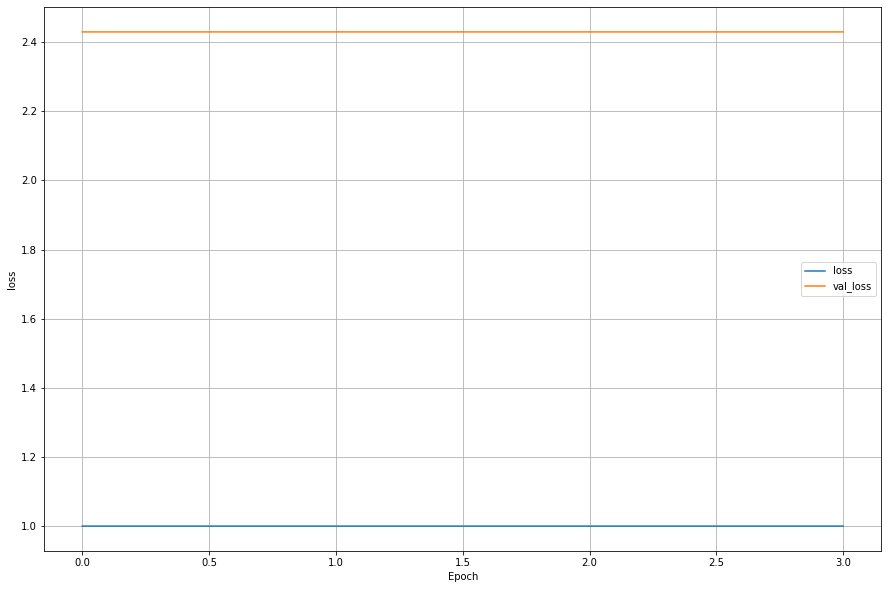

In [73]:
plot_loss(history, 'loss')

In [74]:
lstm_single.save_model("lstm_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm_s.model\assets


### LSTM Bidirectional single shot

In [75]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [76]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [77]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 155s 31ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 2/120
4728/4728 [==============================] - 156s 33ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 3/120
4728/4728 [==============================] - 162s 34ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 4/120
4728/4728 [==============================] - 162s 34ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 5/120
4728/4728 [==============================] - 161s 34ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 6/120
4728/4728 [==============================] - 155s 33ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_abs

In [78]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 19s 14ms/step - loss: 2.4299 - mean_absolute_error: 0.9715
Loss: 2.4299468994140625 MAE: 0.9714597463607788
675/675 [==============================] - 9s 14ms/step - loss: 1.3213 - mean_absolute_error: 0.7939
Loss: 1.321304202079773 MAE: 0.7939086556434631


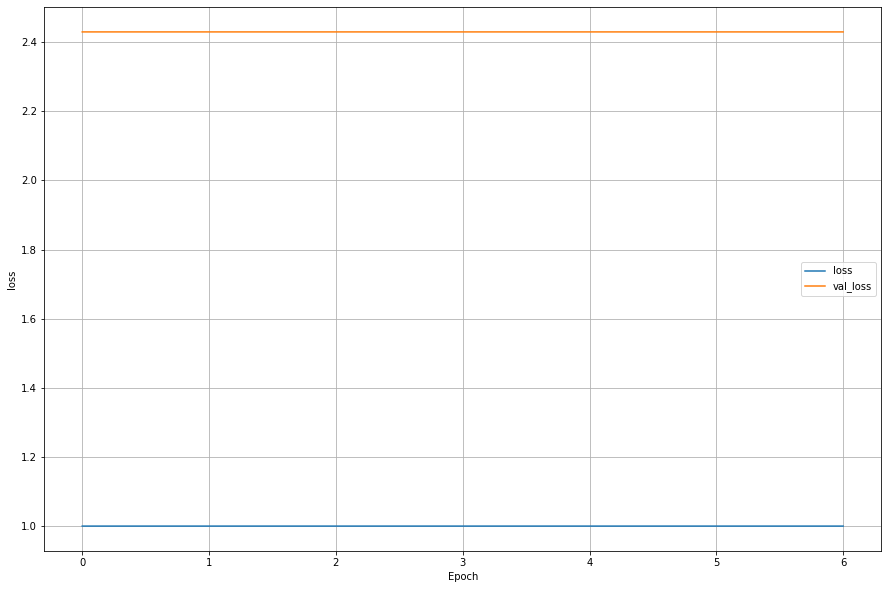

In [79]:
plot_loss(history, 'loss')

In [80]:
lstm_bidi_single.save_model("l_b_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_b_s.model\assets


### GRU single shot

In [81]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(256, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [82]:
gru_single = MyModel(gru_model_single)

In [83]:
history = gru_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 62s 13ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 2/120
4728/4728 [==============================] - 55s 12ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 3/120
4728/4728 [==============================] - 56s 12ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 4/120
4728/4728 [==============================] - 56s 12ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 5/120
4728/4728 [==============================] - 59s 12ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 6/120
4728/4728 [==============================] - 59s 13ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_

In [84]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 6s 5ms/step - loss: 2.4299 - mean_absolute_error: 0.9715
Loss: 2.4299476146698 MAE: 0.9714574813842773
675/675 [==============================] - 3s 4ms/step - loss: 1.3213 - mean_absolute_error: 0.7939
Loss: 1.3213024139404297 MAE: 0.7939061522483826


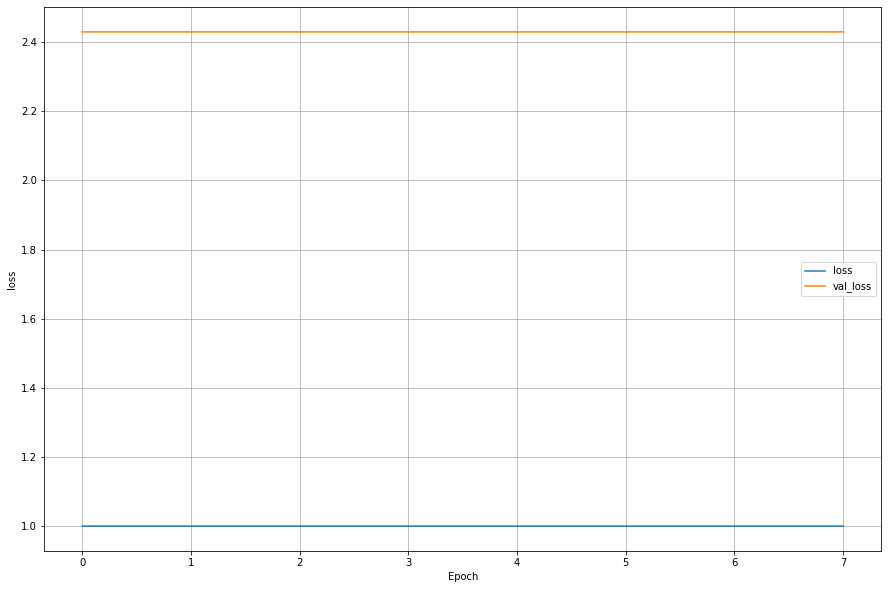

In [85]:
plot_loss(history, 'loss')

In [86]:
gru_single.save_model("gru_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru_s.model\assets


### GRU Bidirectional single shot

In [87]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [88]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [89]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 106s 21ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 2/120
4728/4728 [==============================] - 100s 21ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 3/120
4728/4728 [==============================] - 102s 22ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715
Epoch 4/120
4728/4728 [==============================] - 101s 21ms/step - loss: 0.9997 - mean_absolute_error: 0.6789 - val_loss: 2.4299 - val_mean_absolute_error: 0.9715


In [90]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 12s 9ms/step - loss: 2.4299 - mean_absolute_error: 0.9715
Loss: 2.429945468902588 MAE: 0.9714581966400146
675/675 [==============================] - 6s 9ms/step - loss: 1.3213 - mean_absolute_error: 0.7939
Loss: 1.3213012218475342 MAE: 0.7939054369926453


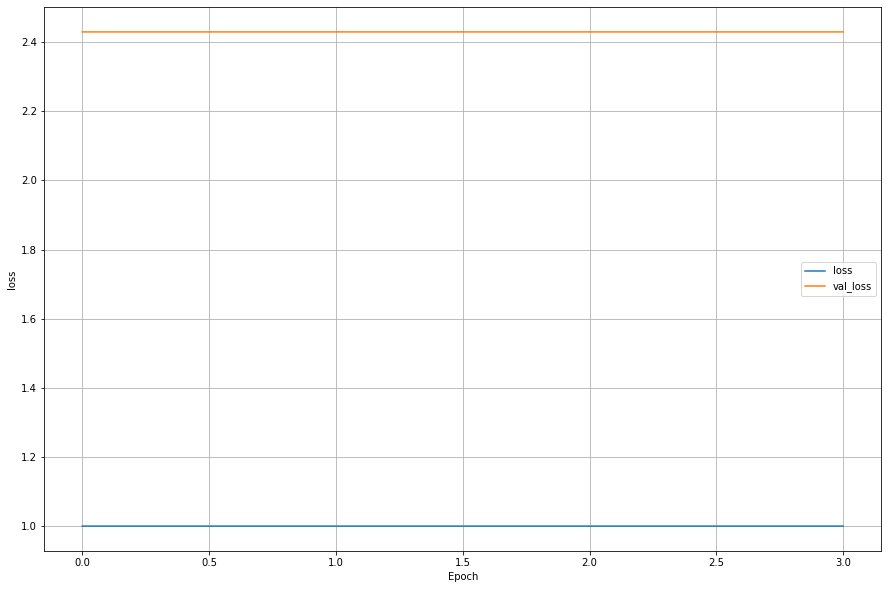

In [91]:
plot_loss(history, 'loss')

In [92]:
gru_bidi_single.save_model("g_b_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_b_s.model\assets
